In [1]:
#default_exp verbatims/standard_themes_meta

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Verbatims - Standard Themes: Meta

> This module defines the training configuration object, data preparation, training, optimization, and inference code for our multimodal classification/regression task that, given a verbatim and a related standard theme, predicts the sentiment of the verbatim relative to the theme (regression) and whether it should be used as an example of that theme (classification)

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm
from fastai.text.all import *
from fastai import metrics as fa_metrics
from transformers import *

import optuna

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *
from blurr.modeling.all import MultiTargetLoss

from tritonlytics_ai.utils import *

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

[nltk_data] Downloading package wordnet to /home/wgilliam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1+cu110
Using fastai 2.2.7
Using transformers 4.3.3


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Training configuration

In [8]:
#export
train_config = {
    'm_pre': '',
    'm_suf': '_multilabel_hf',
    'base_model_name': 'verbatim_standard_theme_meta',
    
    'orig_txt_cols': ['theme', 'answer_text'],
    'txt_cols': ['_theme_', '_text_'],
    'max_seq_length': 256,
    'batch_size': 8,
    'corpus_suf': '_multitask',
    'train_data': STANDARD_THEME_META_PATH/'train.csv',
    'valid_data': STANDARD_THEME_META_PATH/'test.csv',
    
    'opt_beta': 0.5, 
    'opt_beta_average': 'binary',
    'opt_beta_sample_weight': None,
    'opt_start': 0.08, 
    'opt_end': 0.7,
    
    'save_model_monitor': 'valid_loss', 
    'save_model_comp': np.less,
    'learner_path': STANDARD_THEME_META_PATH
}

train_config.update({
    'cache_data_path': STANDARD_THEME_META_PATH/f"data_{train_config['base_model_name']}.pkl",
    'save_model_filename': f"{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}_bestmodel",
    'export_filename': f"{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}_export.pkl",
})

In [9]:
train_config

{'m_pre': '',
 'm_suf': '_multilabel_hf',
 'base_model_name': 'verbatim_standard_theme_meta',
 'orig_txt_cols': ['theme', 'answer_text'],
 'txt_cols': ['_theme_', '_text_'],
 'max_seq_length': 256,
 'batch_size': 8,
 'corpus_suf': '_multitask',
 'train_data': Path('data/classification/standard_themes/meta/train.csv'),
 'valid_data': Path('data/classification/standard_themes/meta/test.csv'),
 'opt_beta': 0.5,
 'opt_beta_average': 'binary',
 'opt_beta_sample_weight': None,
 'opt_start': 0.08,
 'opt_end': 0.7,
 'save_model_monitor': 'valid_loss',
 'save_model_comp': <ufunc 'less'>,
 'learner_path': Path('data/classification/standard_themes/meta'),
 'cache_data_path': Path('data/classification/standard_themes/meta/data_verbatim_standard_theme_meta.pkl'),
 'save_model_filename': 'verbatim_standard_theme_meta_multilabel_hf_bestmodel',
 'export_filename': 'verbatim_standard_theme_meta_multilabel_hf_export.pkl'}

## Data

Prepare the data source

In [10]:
train_df = pd.read_csv(train_config['train_data'])
valid_df = pd.read_csv(train_config['valid_data'])

In [11]:
train_df.head(2)

,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,standard_theme_id,theme,url_friendly_theme,theme_display_order,avg_sentiment,is_example
0,660454,93069,"""Academics at UC ANR value my contributions.""\r\n""Staff members at UC ANR value my contributions...",NaN,English,396,47,SAW,UCANR,480552,None,Please provide any additional feedback regarding the work environment at UC ANR. Your comments w...,Verbatim-Comments,1141.0,Comments re Work Environment at UC ANR,Comments,None,None,None,3.0,250400.0,6984,999999.0,UC Agriculture & Natural Resources,200000.0,AVP Programs and Initiatives,250000.0,Strategic Institutes and Statewide Programs,250400.0,Statewide IPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,Have Voice within my Institution/Valued Member of my Institution,HaveVoiceWithinMyInstitutionValuedMemberOfMyInstitution,1,2.0,0
1,589692,2576,*The MSO of this department consistently takes unfair advantage of power dynamics to intimidate ...,NaN,English,212,9,SAW,UCSD,447156,C&B,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,1240.0,Conduct & Behavioral - Comments,Conduct & Behavioral,None,None,None,3.0,10104.0,3437,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10003.0,ARTS & HUMANITIES,10104.0,MUSIC,NaN,NaN,NaN,NaN,NaN,NaN,19,Supervisor Effectiveness/Resolves Staff Issues,SupervisorEffectivenessResolvesStaffIssues,1,1.0,0


In [12]:
train_df.is_example.dtype

dtype('int64')

Remove any rows where the "txt_col" are nan

In [13]:
train_df.dropna(subset=train_config['orig_txt_cols'], inplace=True)
valid_df.dropna(subset=train_config['orig_txt_cols'], inplace=True)

Add a labels column

In [14]:
#hide
# list(set(train_df.theme.unique()))

Consolodate datasets and add a standard column for the text data to be trained on

In [15]:
train_df['is_valid'] = False
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])
df[train_config['txt_cols']] = df[train_config['orig_txt_cols']]

len(df)

13413

In [9]:
#export
def get_train_data(train_config_updates={}):
    config = {**train_config, **train_config_updates}
    
    train_df = pd.read_csv(config['train_data'])
    train_df.dropna(subset=config['orig_txt_cols'], inplace=True)
    train_df.reset_index(drop=True, inplace=True)
    train_df['is_valid'] = False
    train_df[train_config['txt_cols']] = train_df[train_config['orig_txt_cols']]
    
    if ('valid_data' in config and config['valid_data'] is not None):
        valid_df = pd.read_csv(config['valid_data'])
        valid_df.dropna(subset=config['orig_txt_cols'], inplace=True)
        valid_df.reset_index(drop=True, inplace=True)
        valid_df['is_valid'] = True
        valid_df[train_config['txt_cols']] = valid_df[train_config['orig_txt_cols']]
        
        return pd.concat([train_df, valid_df])
    
    return train_df

In [17]:
df = get_train_data()
test(len(df), 0, operator.ge)

Using the mid-level `DataBlocks` API

In [18]:
#hide
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [19]:
#hide
blocks = (
    HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    RegressionBlock(),
    CategoryBlock()
)

def get_x(inp): return ': '.join(inp[train_config['txt_cols']].values)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x, 
                   get_y=[ColReader('avg_sentiment'), ColReader('is_example')], 
                   splitter=ColSplitter(col='is_valid'), 
                   n_inp=1)

In [20]:
#hide
set_seed(TL_RAND_SEED)
dls = dblock.dataloaders(df, bs=train_config['batch_size'], num_workers=0)

In [21]:
#hide
print(f'The Target vocab has ({len(dls.vocab)} items)')

The Target vocab has (2 items)


In [22]:
#hide
print((f'The inputs vocab ({dls.before_batch[0].hf_tokenizer.vocab_size} items), '
       f'and the targets ({len(dls.vocab)} items)'))

The inputs vocab (50265 items), and the targets (2 items)


In [23]:
#hide
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape, b[2].shape, b[1].type(), b[2].type()

(3,
 torch.Size([8, 465]),
 torch.Size([8]),
 torch.Size([8]),
 'torch.cuda.FloatTensor',
 'torch.cuda.LongTensor')

In [24]:
#hide
dls.show_batch(dataloaders=dls, max_n=2)

,text,text_,category
0,"Supervisor Effectiveness/Resolves Staff Issues: In the Enterprise Network and Telecommunications group of ITS, the environment continues to be toxic, retaliatory, abusive, and discriminatory as in past years. Under the direction of James Seddon, supervisor Malerie Samadi harasses and talks down to employees. Manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them. Also, use the same practice to provide their friends with higher performance ratings and award them with higher merit increases. Senior management continues to harbor this behavior without any consequence and or accountability. James and Malerie exploit minorities and give preferential treatment to personnel hired by them. Regularly abuse the power that the University of California gives them and exercise nepotism because they are both product of such practices.\r\nOther supervisors like Ynez Hicks also participates in the same practices of despotism, nepotism, and favoritism. \r\nIt is unacceptable that this behavior and practices continue to be used by management without any accountability. Principles of the community are ignored continuously daily. When this type of situation is brought up to Human Resources, they ignore them because no one is enforcing the UC Principles. James Seddon and Malerie Samadi in the Datacom group don't care about staff promotion, compensation, and well being. They only care about themselves and their friends. Hiring practices are unfair; they manipulate the process so they can hire barely qualified personnel into experienced positions. Existing staff is overworked because newer personnel can not pull their weight, yet Malerie and James make it look like they are in their appraisals. They mentally abuse staff and minimize their work performance. Recently one of the team member past away while working at home. A stroke caused by the stress and the pressure that Malerie was putting on David Ramirez. She used him to get her promotion to supervisor and make her look good in front of others.\r\nBoth James and Malerie are the perfect examples of bad management. Somehow they continue to occupy their positions, and Senior Management doesn't do anything about it. \r\nThe lowest level the Datacom team has been in years, all because of James and Malerie's arrogance and lack of ethics.",1.0,0
1,"Have Voice within my Institution/Valued Member of my Institution: It is tough to answer the questions this year. \r\nI used to know my resources, and feel positively about training. I do not feel the same since ESR. RSC has limited job functionality because OFC was rolled-out without appropriate reporting and or cost transfers. We have spent many frustrating hours trying to figure out how to access the systems and functions that are up and running (Path). We are left on the front lines with faculty and departments with inadequate tools to help.\r\nThe issues above do not make me feel valued as a member of the UC San Diego community or like leadership listens. It feels like no one even stopped to think about what a fund manager does, and how they will be able to continue those functions in the new systems. \r\nI realize now it is hard for me to comment on inclusion. I think we do a good job, or at least try to, but I am not in a group that would have ever felt excluded based on my background or orientation. \r\nAmount of work remains an issue. The job expands to the hours allotted. We could do a lot better, more thorough and thoughtful work if we had some space to breath and think. Instead we are running from one fire to the next. Many areas had to learn 1 new ESR system. We had to learn ALL of them. It's WAY too much. On top of already having more than enough work to fill every minute of a 40 hr week. And we have learned that somewhere in the ESR process, it was decided (without our knowledge/input/concurrence) that we would take on more duties. Yay.",2.0,0

Codify building training dls with optional caching

In [10]:
#export
def get_train_x(inp, txt_cols): return 'theme: ' + ' comment: '.join(inp[txt_cols].values)

def get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, 
                  train_config_updates={}, use_cache=False):
    
    config = {**train_config, **train_config_updates}
    cache_path = config['cache_data_path'] if ('cache_data_path' in config) else None
    
    if (use_cache and cache_path is not None):
        if (os.path.isfile(cache_path)): 
            dls = torch.load(cache_path)
            dls.bs = config['batch_size']
            return dls
    
    blocks = (
        HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=config['max_seq_length']), 
        RegressionBlock(),
        CategoryBlock()
    )

    dblock = DataBlock(blocks=blocks, 
                   get_x=partial(get_train_x, txt_cols=config['txt_cols']),
                   get_y=[ColReader('avg_sentiment'), ColReader('is_example')], 
                   splitter=ColSplitter(col='is_valid'), 
                   n_inp=1)
    
    set_seed(TL_RAND_SEED)
    dls = dblock.dataloaders(df, bs=config['batch_size'], num_workers=0)
    if (cache_path is not None): torch.save(dls, config['cache_data_path'])
        
    return dls

Tests

In [26]:
df = get_train_data()
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model)

test_eq(dls.bs, train_config['batch_size'])
test_eq(2, len(dls.vocab))

b = dls.one_batch()
test_eq(len(b), 3)
test_eq(b[1].shape[0], dls.bs)    # = regression task
test_eq(b[2].shape[0], dls.bs)    # = classification task

In [27]:
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, use_cache=True)

test_eq(dls.bs, train_config['batch_size'])
test_eq(2, len(dls.vocab))

b = dls.one_batch()
test_eq(len(b), 3)
test_eq(b[1].shape[0], dls.bs)    # = regression task
test_eq(b[2].shape[0], dls.bs)    # = classification task

In [28]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,text_,category
0,"theme: Supervisor Effectiveness/Resolves Staff Issues comment: In the Enterprise Network and Telecommunications group of ITS, the environment continues to be toxic, retaliatory, abusive, and discriminatory as in past years. Under the direction of James Seddon, supervisor Malerie Samadi harasses and talks down to employees. Manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them. Also, use the same practice to provide their friends with higher performance ratings and award them with higher merit increases. Senior management continues to harbor this behavior without any consequence and or accountability. James and Malerie exploit minorities and give preferential treatment to personnel hired by them. Regularly abuse the power that the University of California gives them and exercise nepotism because they are both product of such practices.\r\nOther supervisors like Ynez Hicks also participates in the same practices of despotism, nepotism, and favoritism. \r\nIt is unacceptable that this behavior and practices continue to be used by management without any accountability. Principles of the community are ignored continuously daily. When this type of situation is brought up to Human Resources, they ignore them because no one is enforcing the UC Principles. James Seddon and",1.0,0
1,"theme: Favoritism/Cliques comment: In the Enterprise Network and Telecommunications group of ITS, the environment continues to be toxic, retaliatory, abusive, and discriminatory as in past years. Under the direction of James Seddon, supervisor Malerie Samadi harasses and talks down to employees. Manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them. Also, use the same practice to provide their friends with higher performance ratings and award them with higher merit increases. Senior management continues to harbor this behavior without any consequence and or accountability. James and Malerie exploit minorities and give preferential treatment to personnel hired by them. Regularly abuse the power that the University of California gives them and exercise nepotism because they are both product of such practices.\r\nOther supervisors like Ynez Hicks also participates in the same practices of despotism, nepotism, and favoritism. \r\nIt is unacceptable that this behavior and practices continue to be used by management without any accountability. Principles of the community are ignored continuously daily. When this type of situation is brought up to Human Resources, they ignore them because no one is enforcing the UC Principles. James Seddon and Malerie Sam",1.0,0


## Training

Configure our **metrics**

In [11]:
#export
# define metrics
def sentiment_mse(preds, *targs):
    return fa_metrics.mse(preds[0], targs[0])

def is_example_acc(preds, *targs):
    return fa_metrics.accuracy(preds[1], targs[1])

In [12]:
#export
def get_metrics(train_config_updates={}):
    config = {**train_config, **train_config_updates}
    return [ sentiment_mse, is_example_acc ]

Configure our **loss**

In [31]:
#hide
is_example_weights = list(np.max(train_df.is_example.value_counts()) /train_df.is_example.value_counts())
print(is_example_weights)

[1.0, 148.02469135802468]


In [32]:
#hide
# define our custom multi-target loss
loss_func = MultiTargetLoss(loss_classes=[MSELossFlat, CrossEntropyLossFlat],
                            loss_classes_kwargs=[{}, {'weight': FloatTensor(is_example_weights).to('cuda:1')}],
                            weights=[1, 0.1], 
                            reduction='mean')

In [13]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    loss_classes_kwargs = [{}, {}]
    
    if (use_weighted and train_df is not None):
        is_example_weights = list(np.max(train_df.is_example.value_counts()) /train_df.is_example.value_counts())
        loss_classes_kwargs[1] = {'weight': FloatTensor(is_example_weights).to(dls.device)}
    
    loss_func = MultiTargetLoss(loss_classes=[MSELossFlat, CrossEntropyLossFlat],
                                loss_classes_kwargs=loss_classes_kwargs,
                                weights=[1, 0.1], 
                                reduction='mean')
        
    return loss_func

In [34]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), MultiTargetLoss)

In [35]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), MultiTargetLoss)
test_eq(len(tst_loss_func.loss_funcs[1].func.weight), len(dls.c))
test_eq(dls.device, tst_loss_func.loss_funcs[1].func.weight.device)

Configure our **callbacks**

In [14]:
#export
class Meta_MM_HF_BaseModelCallback(HF_BaseModelCallback):
    def __init__(self, cls_idx=0):
        super().__init__()
        self.cls_idx = cls_idx
        
    def after_pred(self):
        super().after_pred()
        if (self.learn.pred[0].dim() == 3):
            self.learn.pred = (self.learn.pred[0][:,self.cls_idx,:], self.learn.pred[1][:,self.cls_idx,:])

In [26]:
#export
def get_cbs(train_config_updates={}, add_save_model_cb=True):
    config = {**train_config, **train_config_updates}
    fit_cbs = []
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)
    
    if (add_save_model_cb): fit_cbs.append(best_model_cb)
    
    return [Meta_MM_HF_BaseModelCallback], fit_cbs # (learn_cbs, fit_cbs)

Configure our **final model** by updating our hf_model.classifier for multi-modal tasks

In [38]:
#hide

# class Meta_MM(Module):
#     def __init__(self, in_features=768, inner_dim=768, p=0.0): 
#         super().__init__()
#         self.dense = nn.Linear(in_features, inner_dim)
#         self.dropout = nn.Dropout(p=p)
#         self.pred_is_example = nn.Linear(inner_dim, 2, bias=False)
#         self.pred_avg_sentiment = nn.Linear(inner_dim, 1, bias=False)
#         self.pred_avg_sent_range = SigmoidRange(1., 5.1)
        
#     def forward(self, x):
#         x = self.dropout(x)
#         x = self.dense(x)
#         x = torch.tanh(x)
#         x = self.dropout(x)
#         is_example = self.pred_is_example(x)
#         avg_sentiment = self.pred_avg_sent_range(self.pred_avg_sentiment(x))
        
#         return avg_sentiment, is_example

In [15]:
#export
class Meta_MM(Module):
    def __init__(self, in_features=50): 
        super().__init__()
        self.pred_is_example = nn.Linear(in_features, 2, bias=False)
        self.pred_avg_sentiment = nn.Linear(in_features, 1, bias=False)
        self.pred_avg_sent_range = SigmoidRange(1., 5.1)
        
    def forward(self, x):
        is_example = self.pred_is_example(x)
        avg_sentiment = self.pred_avg_sent_range(self.pred_avg_sentiment(x))
        
        return avg_sentiment, is_example

In [40]:
#hide
last_layer = list(hf_model.named_children())[-1]

In [41]:
#hide
last_layer_name = last_layer[0]; last_layer_name

'classification_head'

In [42]:
#hide
in_features = hf_model._modules[last_layer_name].dense.in_features

In [43]:
#hide
# hf_model._modules[last_layer_name] = Meta_MM(in_features=in_features)

In [44]:
#hide
# in_features = list(last_layer[1].children())[0].in_features; in_features
# mm_model = nn.Sequential(list(hf_model.named_children())[:-1][0][1])
# mm_model.add_module(name='classifier', module=MM(in_features=768))
# hf_model._modules['classifier'] = hf_model._modules.pop(last_layer_name)

Configure our **Learner**

In [45]:
#hide
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [16]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, wd=0.1),
                add_save_model_cb=True, train_config_updates={}):
    
    config = {**train_config, **train_config_updates}
    
    # swap out classifier for our Meta_MM module
    last_layer = list(hf_model.named_children())[-1]
    last_layer_name = last_layer[0]
    in_features = hf_model._modules[last_layer_name].dense.in_features
    hf_model._modules[last_layer_name] = Meta_MM(in_features=in_features)
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config, add_save_model_cb=add_save_model_cb)
    learn_metrics = get_metrics(config)

    set_seed(TL_RAND_SEED)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

In [47]:
train_config_updates={'save_model_filename': f"exp_{train_config['save_model_filename']}" }
                      
learn, fit_cbs = get_learner(hf_model, dls, train_df, train_config_updates=train_config_updates)

In [48]:
# learn.blurr_summary()

In [49]:
# learn.show_training_loop()

(0.003981071710586548, 1.0964781722577754e-06)

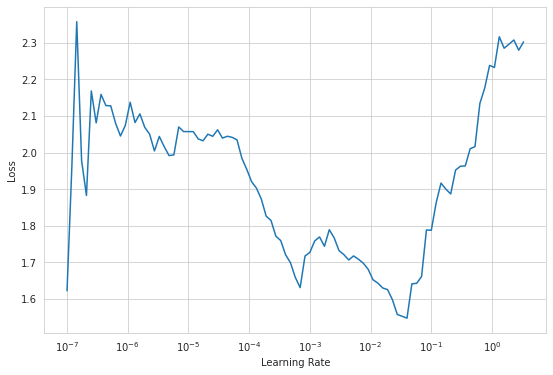

In [50]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [51]:
lr = lr_min; lr_min

0.003981071710586548

In [52]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,sentiment_mse,is_example_acc,time
0,0.451275,0.455106,0.451222,0.993294,03:06


Better model found at epoch 0 with valid_loss value: 0.45510587096214294.


(3.311311274956097e-07, 0.002511886414140463)

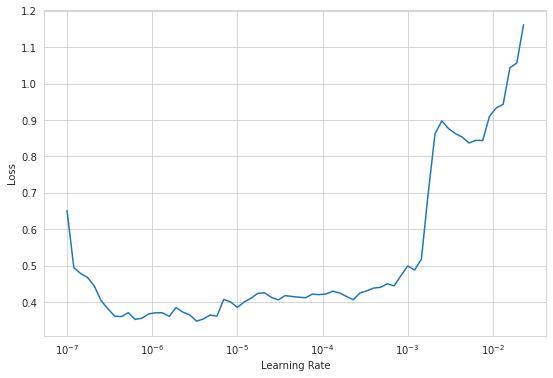

In [53]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [54]:
lr = lr_min; lr_min

3.311311274956097e-07

In [55]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(10, lr_max=slice(lr/10, lr), cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,sentiment_mse,is_example_acc,time
0,0.444798,0.453417,0.449536,0.993294,05:18
1,0.503554,0.447229,0.443352,0.993294,05:19
2,0.477169,0.443810,0.439936,0.993294,05:20
3,0.400236,0.442045,0.438180,0.993294,05:21
4,0.396645,0.442302,0.438444,0.993294,05:21
5,0.495828,0.441175,0.437319,0.993294,05:21
6,0.480493,0.440538,0.436687,0.993294,05:21
7,0.409209,0.440267,0.436419,0.993294,05:22
8,0.430810,0.440109,0.436261,0.993294,05:22
9,0.422115,0.440022,0.436175,0.993294,05:22


Better model found at epoch 0 with valid_loss value: 0.45341694355010986.
Better model found at epoch 1 with valid_loss value: 0.44722941517829895.
Better model found at epoch 2 with valid_loss value: 0.44380953907966614.
Better model found at epoch 3 with valid_loss value: 0.4420449733734131.
Better model found at epoch 5 with valid_loss value: 0.4411749243736267.
Better model found at epoch 6 with valid_loss value: 0.4405377507209778.
Better model found at epoch 7 with valid_loss value: 0.44026699662208557.
Better model found at epoch 8 with valid_loss value: 0.44010862708091736.
Better model found at epoch 9 with valid_loss value: 0.44002217054367065.


In [56]:
learn.save(f"exp_{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}")

Path('data/classification/standard_themes/meta/models/exp_verbatim_standard_theme_meta_multilabel_hf.pth')

Look at results

In [57]:
learn.show_results(learner=learn, max_n=2) 

,text,text_,category,target1,target2
0,"theme: Advancement and Training Opportunities comment: 1.\tSensitivity and bias training for SLBO management – The selection and search for the person to fill Evelyns position seemed inequitable. Evelyn having a say in her successor may not have been against campus hiring policies but did not seem appropriate since she had inside knowledge of some of the candidates and a possible bias for or against other candidates. \r\n I applied for the position because my applying was suggested by another member of Evelyns team that was not on the committee.\r\nAnna, a member of the committee, was also under the leadership of Evelyn. Anna, who now has been promoted into Jamies positions would not be in Jamies position if he had not gotten Evelyns position. In addition, there was no one in the room from HR ensuring that the interviews were fair and equal. I think that this Cluster is large enough to warrant additional oversite with the filling of positions. \r\nThough it may not matter to some but within the SLBO all of senior management (HR remains neutral) is now male while 99 % of the rest of the staff is female. \r\n2.\t",3.0,0,"(2.078125,)",0
1,"theme: Fear of Retaliation, Negative Consequences comment: Staff no longer receive COLAs, like the faculty do--we are instead told that our COLA is a merit increase and expected to believe this.\r\n\r\nThis is incredibly demoralizing and many talented staff with institutional longevity are considered leaving UCSD for higher compensation elsewhere, at least as far as I am able to report by personal conversation. The turnover loss to the department if this were to happen would be substantial. Experienced career staff have knowledge that they can generalize from to solve the unique problems that arise frequently in the university setting. New staff cannot always provide these solutions to faculty.\r\n\r\nFurther our'merit increases' were not announced in a timely manner and apparently do not include July, that is, they are effective Aug 1. I do not think our faculty would accept this! It is true that the faculty attract fee-paying students to campus but the institution truly is a three legged stool--charitably I do not think our department could be run with faculty alone.\r\n\r\nAsides from compensation, which is an UCOP / EVCAA issue, Mathematics is a good department",3.0,0,"(2.109375,)",0


In [58]:
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate())); scores

{'valid_loss': 0.44002217054367065,
 'sentiment_mse': 0.43617454171180725,
 'is_example_acc': 0.9932935833930969}

In [59]:
learn = learn.load(f"exp_{train_config['save_model_filename']}")
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Validation Loss: 0.44002217054367065


In [60]:
for prob_sent, prob_example, targ_sent, targ_example in zip(*probs,*targs):
    print(prob_sent, targ_sent, torch.argmax(prob_example, dim=-1), targ_example)

tensor([2.0039]) tensor(3.) tensor(0) tensor(0)
tensor([4.2305]) tensor(4.) tensor(0) tensor(0)
tensor([4.3672]) tensor(4.) tensor(0) tensor(0)
tensor([1.9053]) tensor(2.) tensor(0) tensor(0)
tensor([2.8281]) tensor(2.) tensor(0) tensor(0)
tensor([3.9570]) tensor(4.) tensor(0) tensor(0)
tensor([1.8750]) tensor(1.) tensor(0) tensor(0)
tensor([3.0312]) tensor(2.) tensor(0) tensor(0)
tensor([2.1094]) tensor(3.) tensor(0) tensor(0)
tensor([3.9785]) tensor(4.) tensor(0) tensor(0)
tensor([1.9111]) tensor(2.) tensor(0) tensor(0)
tensor([4.4297]) tensor(4.) tensor(0) tensor(0)
tensor([3.1777]) tensor(2.) tensor(0) tensor(0)
tensor([2.3047]) tensor(2.) tensor(0) tensor(0)
tensor([2.8398]) tensor(4.) tensor(0) tensor(0)
tensor([1.8066]) tensor(2.) tensor(0) tensor(0)
tensor([4.2969]) tensor(4.) tensor(0) tensor(0)
tensor([1.8945]) tensor(2.) tensor(0) tensor(0)
tensor([1.8691]) tensor(2.) tensor(0) tensor(0)
tensor([1.7959]) tensor(1.5000) tensor(0) tensor(0)
tensor([1.8809]) tensor(2.) tensor(0

tensor([2.0430]) tensor(2.) tensor(0) tensor(1)
tensor([2.0078]) tensor(2.) tensor(0) tensor(0)
tensor([4.0156]) tensor(5.) tensor(0) tensor(0)
tensor([2.2500]) tensor(2.) tensor(0) tensor(0)
tensor([2.0352]) tensor(2.) tensor(0) tensor(0)
tensor([2.1855]) tensor(2.) tensor(0) tensor(0)
tensor([2.8281]) tensor(2.5000) tensor(0) tensor(0)
tensor([2.1328]) tensor(2.) tensor(0) tensor(0)
tensor([2.0547]) tensor(2.) tensor(0) tensor(0)
tensor([3.6973]) tensor(5.) tensor(0) tensor(0)
tensor([2.6230]) tensor(2.) tensor(0) tensor(0)
tensor([2.0293]) tensor(3.) tensor(0) tensor(0)
tensor([2.2676]) tensor(1.) tensor(0) tensor(0)
tensor([1.9766]) tensor(2.) tensor(0) tensor(0)
tensor([1.8262]) tensor(2.) tensor(0) tensor(0)
tensor([3.4805]) tensor(4.) tensor(0) tensor(0)
tensor([1.7598]) tensor(1.) tensor(0) tensor(0)
tensor([2.3359]) tensor(4.) tensor(0) tensor(0)
tensor([1.9756]) tensor(2.) tensor(0) tensor(0)
tensor([3.7812]) tensor(4.) tensor(0) tensor(0)
tensor([2.1602]) tensor(2.) tensor(0

tensor([1.9004]) tensor(1.5000) tensor(0) tensor(0)
tensor([4.4375]) tensor(5.) tensor(0) tensor(0)
tensor([1.9355]) tensor(1.) tensor(0) tensor(0)
tensor([2.2500]) tensor(1.) tensor(0) tensor(0)
tensor([1.9199]) tensor(2.) tensor(0) tensor(0)
tensor([2.0586]) tensor(2.) tensor(0) tensor(0)
tensor([2.6387]) tensor(4.) tensor(0) tensor(0)
tensor([1.8682]) tensor(2.) tensor(0) tensor(0)
tensor([2.0391]) tensor(3.) tensor(0) tensor(0)
tensor([1.8867]) tensor(2.) tensor(0) tensor(0)
tensor([4.2656]) tensor(3.) tensor(0) tensor(0)
tensor([1.9219]) tensor(1.) tensor(0) tensor(0)
tensor([2.0742]) tensor(2.) tensor(0) tensor(0)
tensor([2.0234]) tensor(2.) tensor(0) tensor(0)
tensor([2.0586]) tensor(1.) tensor(0) tensor(0)
tensor([2.1641]) tensor(3.) tensor(0) tensor(0)
tensor([4.3906]) tensor(5.) tensor(0) tensor(0)
tensor([2.3086]) tensor(2.) tensor(0) tensor(0)
tensor([2.1914]) tensor(4.) tensor(0) tensor(0)
tensor([2.7031]) tensor(2.) tensor(0) tensor(0)
tensor([2.1289]) tensor(2.) tensor(0

tensor([3.8672]) tensor(4.) tensor(0) tensor(0)
tensor([1.8105]) tensor(1.) tensor(0) tensor(0)
tensor([2.4414]) tensor(2.) tensor(0) tensor(0)
tensor([1.8750]) tensor(2.) tensor(0) tensor(0)
tensor([4.0547]) tensor(4.) tensor(0) tensor(0)
tensor([3.7051]) tensor(3.) tensor(0) tensor(0)
tensor([1.9824]) tensor(2.) tensor(0) tensor(0)
tensor([2.0020]) tensor(2.) tensor(0) tensor(0)
tensor([2.0254]) tensor(2.) tensor(0) tensor(0)
tensor([2.4688]) tensor(2.) tensor(0) tensor(0)
tensor([1.8730]) tensor(2.) tensor(0) tensor(0)
tensor([2.0645]) tensor(2.) tensor(0) tensor(0)
tensor([3.2871]) tensor(4.) tensor(0) tensor(0)
tensor([2.0781]) tensor(2.) tensor(0) tensor(0)
tensor([1.9424]) tensor(2.) tensor(0) tensor(0)
tensor([1.9805]) tensor(2.) tensor(0) tensor(0)
tensor([1.9355]) tensor(3.) tensor(0) tensor(0)
tensor([2.3242]) tensor(2.) tensor(0) tensor(0)
tensor([2.0742]) tensor(2.) tensor(0) tensor(0)
tensor([2.1758]) tensor(3.) tensor(0) tensor(0)
tensor([3.0215]) tensor(2.) tensor(0) te

tensor([2.0977]) tensor(3.) tensor(0) tensor(0)
tensor([2.0039]) tensor(2.) tensor(0) tensor(0)
tensor([1.7754]) tensor(1.) tensor(0) tensor(0)
tensor([2.4531]) tensor(2.) tensor(0) tensor(0)
tensor([1.9414]) tensor(2.) tensor(0) tensor(0)
tensor([1.8789]) tensor(2.) tensor(0) tensor(0)
tensor([3.8613]) tensor(3.) tensor(0) tensor(0)
tensor([2.1680]) tensor(2.) tensor(0) tensor(0)
tensor([3.1602]) tensor(2.) tensor(0) tensor(0)
tensor([1.9590]) tensor(3.) tensor(0) tensor(0)
tensor([1.9941]) tensor(2.) tensor(0) tensor(0)
tensor([1.8525]) tensor(1.) tensor(0) tensor(0)
tensor([2.7461]) tensor(3.) tensor(0) tensor(0)
tensor([2.2695]) tensor(3.) tensor(0) tensor(0)
tensor([2.1016]) tensor(1.) tensor(0) tensor(0)
tensor([4.3984]) tensor(3.) tensor(0) tensor(0)
tensor([2.4648]) tensor(2.) tensor(0) tensor(0)
tensor([1.7363]) tensor(1.) tensor(0) tensor(0)
tensor([2.2461]) tensor(2.) tensor(0) tensor(0)
tensor([1.9824]) tensor(3.) tensor(0) tensor(0)
tensor([2.0078]) tensor(2.) tensor(0) te

tensor([3.8496]) tensor(5.) tensor(0) tensor(0)
tensor([1.9805]) tensor(2.) tensor(0) tensor(0)
tensor([2.0801]) tensor(3.) tensor(0) tensor(0)
tensor([1.9297]) tensor(1.) tensor(0) tensor(0)
tensor([2.6133]) tensor(3.) tensor(0) tensor(0)
tensor([1.9277]) tensor(2.) tensor(0) tensor(0)
tensor([4.3555]) tensor(5.) tensor(0) tensor(0)
tensor([2.9629]) tensor(4.) tensor(0) tensor(0)
tensor([2.0078]) tensor(2.) tensor(0) tensor(0)
tensor([2.2070]) tensor(2.) tensor(0) tensor(0)
tensor([1.7793]) tensor(2.) tensor(0) tensor(0)
tensor([2.1094]) tensor(2.) tensor(0) tensor(0)
tensor([1.9102]) tensor(2.) tensor(0) tensor(0)
tensor([2.1367]) tensor(2.) tensor(0) tensor(0)
tensor([2.1230]) tensor(2.) tensor(0) tensor(0)
tensor([1.8955]) tensor(1.) tensor(0) tensor(0)
tensor([2.4141]) tensor(3.) tensor(0) tensor(0)
tensor([2.2656]) tensor(3.) tensor(0) tensor(0)
tensor([1.8457]) tensor(1.) tensor(0) tensor(0)
tensor([2.1328]) tensor(2.) tensor(0) tensor(0)
tensor([4.1680]) tensor(5.) tensor(0) te

tensor([2.7773]) tensor(3.) tensor(0) tensor(0)
tensor([2.4316]) tensor(3.) tensor(0) tensor(0)
tensor([2.]) tensor(2.) tensor(0) tensor(0)
tensor([1.8574]) tensor(2.) tensor(0) tensor(0)
tensor([2.0605]) tensor(1.) tensor(0) tensor(0)
tensor([2.7051]) tensor(5.) tensor(0) tensor(0)
tensor([2.2793]) tensor(2.) tensor(0) tensor(0)
tensor([1.9785]) tensor(2.) tensor(0) tensor(0)
tensor([1.9785]) tensor(2.) tensor(0) tensor(0)


Export model for inference

In [61]:
learn.export(fname=f"exp_{train_config['export_filename']}")

In [62]:
inf_learn = load_learner(f"{train_config['learner_path']}/exp_{train_config['export_filename']}")

In [63]:
STANDARD_THEME_SAW_LABELS[:5]

['adequate_staffing',
 'advancement_and_training_opportunities',
 'appropriate_stress_work_assigned_equitably',
 'benefits',
 'better_ways_recognized_participate_in_decisions']

In [64]:
inf_learn.blurr_predict('theme: Benefits comment: We are not paid enough and the benefits are horrible')

[(((1.9047832489013672), '0'),
  (#2) [tensor([1.9048]),tensor(0)],
  (#2) [tensor([1.9048]),tensor([0.9926, 0.0074])])]

In [65]:
learn.blurr_predict("theme: Adequate Staffing comment: We don't have enough people to get the job done.")

[(((2.09375), '0'),
  (#2) [tensor([2.0938]),tensor(0)],
  (#2) [tensor([2.0938]),tensor([0.9974, 0.0026])])]

## Review

In [66]:
#hide
try: del learn; del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [68]:
#hide
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = "facebook/bart-base" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [69]:
# predictions for a single model using the learner's model and data loaders
set_seed(TL_RAND_SEED)
learn, fit_cbs = get_learner(hf_model, 
                             dls, 
                             train_df=train_df, 
                             use_weighted_loss=False, 
                             use_fp16=True,
                             train_config_updates={})

learn = learn.load(f"exp_{train_config['save_model_filename']}")
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs[0].shape, probs[1].shape, targs[0].shape, targs[1].shape

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(torch.Size([1342, 1]),
 torch.Size([1342, 2]),
 torch.Size([1342]),
 torch.Size([1342]))

### Lets look at validation metrics

In [70]:
is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]
# is_example_prob_true

In [71]:
# determine optimal threshold based on desired f-score
average, sample_weight = train_config['opt_beta_average'], train_config['opt_beta_sample_weight']
    
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [72]:
threshold_f05 = f05.opt_th(is_example_prob_true, targs[1])
threshold_f1 = f1.opt_th(is_example_prob_true, targs[1])
threshold_f2 = f2.opt_th(is_example_prob_true, targs[1])

threshold_f05, threshold_f1, threshold_f2

(0.27, 0.27, 0.27)

In [73]:
f05_score = f05.opt_fscore(is_example_prob_true, targs[1])
f1_score = f1.opt_fscore(is_example_prob_true, targs[1])
f2_score = f2.opt_fscore(is_example_prob_true, targs[1])

f05_score, f1_score, f2_score

(0.010590415673815197, 0.016824395373291272, 0.04089979550102249)

In [74]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs[1], (is_example_prob_true > threshold_f05), beta=.5, 
                      average='binary', sample_weight=None, zero_division=False)
res

0.010590415673815197

In [75]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9932935833930969, 0.9932935833930969, 0.9932935833930969)

In [76]:
# make sure we are getting the same f1 accuracy
preds = ((is_example_prob_true > threshold_f05).byte() == targs[1].byte()).float().mean()
preds.item()

0.30327868461608887

### Overall metrics - is_example_prob_true

In [77]:
eval_targs = targs[1].flatten() # targs[:,0]
eval_probs = is_example_prob_true.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, **"Overall, how often is the classifier correct?"**

In [81]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight))

0.30327868852459017


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, **"What would the accuracy be by always predicting the most frequent case?"**

In [82]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0 1333


In [83]:
most_freq_class_count / len(eval_targs)

0.9932935916542474

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [84]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.0035861591409735993


#### Confusion Matrix

Describes the performance of a classification model

In [85]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [86]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

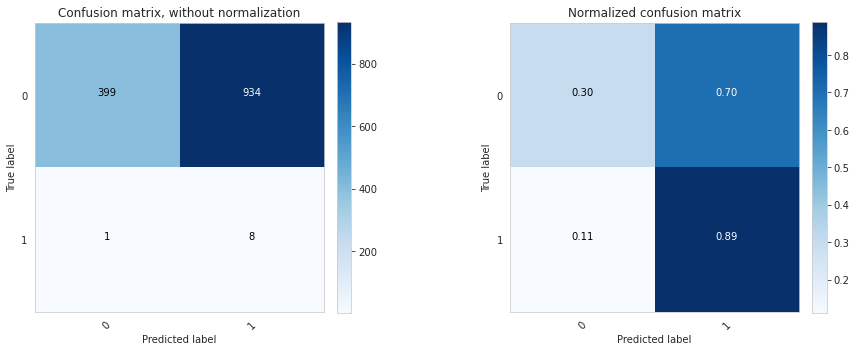

In [87]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [88]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.30      0.46      1333
           1       0.01      0.89      0.02         9

    accuracy                           0.30      1342
   macro avg       0.50      0.59      0.24      1342
weighted avg       0.99      0.30      0.46      1342



#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [89]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

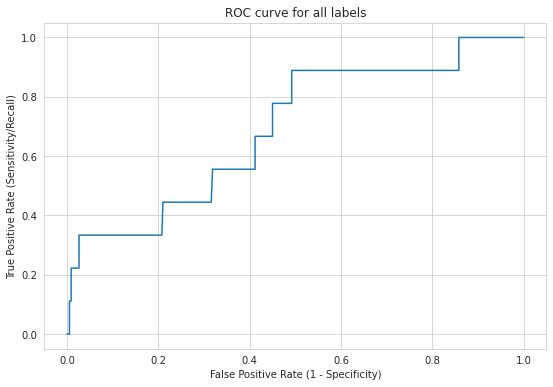

In [90]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [93]:
print(skm.roc_auc_score(eval_targs, eval_probs, average='weighted', sample_weight=None))

0.6912144702842377


### Overall metrics - sentiment

In [94]:
# mse
skm.mean_squared_error(targs[0], probs[0])

0.43617442

In [95]:
# rmse
math.sqrt(skm.mean_squared_error(targs[0], probs[0]))

0.6604350251936353

In [96]:
# mae
skm.mean_absolute_error(targs[0], probs[0])

0.4809825

## Final results


In [97]:
#hide
try: del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [103]:
inf_learn = load_learner(fname=f"{train_config['learner_path']}/exp_{train_config['export_filename']}")
inf_learn.loss_func.loss_funcs[1].func = inf_learn.loss_func.loss_funcs[1].func.to(dls.device)
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, train_config_updates={})
inf_learn.dls = dls

In [114]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs[0].shape, probs[1].shape, targs[0].shape, targs[1].shape, loss.shape

(torch.Size([1342, 1]),
 torch.Size([1342, 2]),
 torch.Size([1342]),
 torch.Size([1342]),
 torch.Size([1342]))

In [115]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [116]:
is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]

In [117]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(is_example_prob_true, targs[1])
threshold_f1 = f1.opt_th(is_example_prob_true, targs[1])
threshold_f2 = f2.opt_th(is_example_prob_true, targs[1])

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(is_example_prob_true, targs[1], threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(is_example_prob_true, targs[1], threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(is_example_prob_true, targs[1], threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(is_example_prob_true, targs[1], sigmoid=False)}')

0.27 0.27 0.27
Fowards Only
-------------
f05:	Optimal threshold = 0.27	(Accuracy = 0.2973174452781677)
f1:	Optimal threshold = 0.27	(Accuracy = 0.2973174452781677)
f2:	Optimal threshold = 0.27	(Accuracy = 0.2973174452781677)

Accuracy: 0.9932935833930969


In [118]:
mae = skm.mean_absolute_error(targs[0], probs[0])
mse = skm.mean_squared_error(targs[0], probs[0])
rmse = math.sqrt(skm.mean_squared_error(targs[0], probs[0]))

mae, mse, rmse

(0.48010173, 0.43516338, 0.6596691433707621)

In [119]:
final_valid_loss = loss.mean().item(); final_valid_loss

0.43901023268699646

## Build our training loop for hyperparam optimization and final training

In [120]:
#hide
try: del learn; del dls
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [36]:
#export
def train(params, trial=None, yyyymmdd = datetime.today().strftime("%Y%m%d"), train_config_updates={}):
    
    config = {**train_config, **train_config_updates}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'

    # 1. grab our huggingface objects
    task = HF_TASKS_AUTO.SequenceClassification
    hf_config = AutoConfig.from_pretrained(params["pretrained_model_name"])
    
    if (f'{params["pretrained_model_name"]}_config_overrides' in params):
        hf_config.update(params[f'{params["pretrained_model_name"]}_config_overrides'])
    else:
        config_overrides = { k:v for k,v in params.items() if (k in hf_config.to_dict()) }
        hf_config.update(config_overrides)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(params["pretrained_model_name"], 
                                                                                   task=task, 
                                                                                   config=hf_config)

    # 2. build our dls and learner
    df = get_train_data(train_config_updates=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    set_seed(TL_RAND_SEED)
    dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, train_config_updates=config, use_cache=False)
    
    set_seed(TL_RAND_SEED)
    learn, fit_cbs = get_learner(hf_model, 
                                 dls, 
                                 train_df=None, 
                                 use_weighted_loss=params["use_weighted_loss"], 
                                 use_fp16=params["use_fp16"],
                                 add_save_model_cb=params['save_model'],
                                 train_config_updates=config)
    
    if (trial is not None): learn.add_cb(FastAIPruningCallbackv2(trial=trial, monitor=params['optimize_for']))
    
    # 3. train
    with learn.no_logging(): 
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_frozen_epochs"], lr_max=params["frozen_lr"], cbs=fit_cbs)
        
        learn.unfreeze()
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_unfrozen_epochs"], 
                            lr_max=slice(params["unfrozen_lr_min"], params["unfrozen_lr_max"]), 
                            cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model if save_mode=True)
        if (trial is None): learn.export(fname=f"{yyyymmdd}_{config['export_filename']}")
        
    # 4. evaluate
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate()))
    
    try:
        if (trial is not None): return scores[params['optimize_for']]
        
        probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)

        # determine optimal threshold based on desired f-score
        average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

        f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)

        is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]
        scores['is_example_f05'], scores['is_example_f1'], scores['is_example_f2'] = {}, {}, {}

        scores['is_example_f05']['threshold'] = f05.opt_th(is_example_prob_true, targs[1])
        scores['is_example_f1']['threshold'] = f1.opt_th(is_example_prob_true, targs[1])
        scores['is_example_f2']['threshold'] = f2.opt_th(is_example_prob_true, targs[1])

        scores['is_example_f05']['score'] = f05.opt_fscore(is_example_prob_true, targs[1])
        scores['is_example_f1']['score'] = f1.opt_fscore(is_example_prob_true, targs[1])
        scores['is_example_f2']['score'] = f2.opt_fscore(is_example_prob_true, targs[1])

        scores['sentiment'] = {
            'mae': skm.mean_absolute_error(targs[0], probs[0]).item(),
            'mse': skm.mean_squared_error(targs[0], probs[0]).item(),
            'rmse': math.sqrt(skm.mean_squared_error(targs[0], probs[0]).item())
        }

        # save scores from validation set if mode == training
        with open(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json", 'w') as f:
            json.dump(scores, f, indent=4)

        # save train/validation probs, targs, losses for review
        test_dl = dls.test_dl(df, with_labels=True)
        probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)
        is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]

        probs_df = pd.DataFrame(np.concatenate((probs[0].numpy(), is_example_prob_true[:,None]), axis=-1), 
                                columns=['pred_sentiment', 'prob_is_example'])
        targs_df = pd.DataFrame(np.concatenate((targs[0].numpy()[:,None], targs[1].numpy()[:,None]), axis=-1), 
                                columns= ['targ_sentiment', 'targ_is_example'])
        losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
        
        final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)

        final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_results.csv", index=False)
        return scores, final_df
    
    finally:
        # cleanup
        del learn; del dls 
        del hf_arch; del hf_config; del hf_tokenizer; del hf_model

### Hyperparameter optimization

In [18]:
#export
def after_trial_cleanup(study, trial):
    gc.collect()
    torch.cuda.empty_cache()

In [30]:
#export
def objective(trial, yyyymmdd = datetime.today().strftime("%Y%m%d"), train_config_updates={}):
    opt_params = {
        'pretrained_model_name': trial.suggest_categorical("pretrained_model_name", ["facebook/bart-base"]),
        
        'save_model': trial.suggest_categorical("save_model", [True, False]), 
        'use_weighted_loss': trial.suggest_categorical("use_weighted_loss", [True, False]),
        'use_fp16': trial.suggest_categorical("use_fp16", [True]),
        'n_frozen_epochs': trial.suggest_int("n_frozen_epochs", 1, 3),
        'n_unfrozen_epochs': trial.suggest_int("n_unfrozen_epochs", 0, 10),
        'frozen_lr': trial.suggest_loguniform("frozen_lr", 1e-4, 1e-3),
        'unfrozen_lr_max': trial.suggest_loguniform("unfrozen_lr_max", 1e-7, 1e-6),
        'unfrozen_lr_min': trial.suggest_loguniform("unfrozen_lr_min", 1e-9, 1e-7),
        'optimize_for': 'valid_loss',
        
        'facebook/bart-base_config_overrides': {
            'activation_dropout': trial.suggest_discrete_uniform('activation_dropout', 0.0, 0.3, 0.05),
            'attention_dropout': trial.suggest_discrete_uniform('attention_dropout', 0.0, 0.3, 0.05),
            'classif_dropout': trial.suggest_discrete_uniform('classif_dropout', 0.0, 0.3, 0.05),
            'dropout': trial.suggest_discrete_uniform('dropout', 0.0, 0.3, 0.05)
        },
        'roberta-base_config_overrides': {
            'attention_probs_dropout_prob': trial.suggest_discrete_uniform('attention_probs_dropout_prob', 0.0, 0.3, 0.05),
            'hidden_dropout_prob': trial.suggest_discrete_uniform('hidden_dropout_prob', 0.0, 0.3, 0.05)
        }
    }
    
    score = train(opt_params, trial=trial, yyyymmdd=yyyymmdd, train_config_updates=train_config_updates)
    return score

In [31]:
yyyymmdd = datetime.today().strftime("%Y%m%d")

In [ ]:
start = datetime.now()

pruner = optuna.pruners.MedianPruner() if True else optuna.pruners.NopPruner()
study = optuna.create_study(direction="minimize", pruner=pruner)

train_config_updates = {}
study.optimize(partial(objective, yyyymmdd=yyyymmdd, train_config_updates=train_config_updates), 
               n_trials=30, 
               callbacks=[after_trial_cleanup])#, timeout=600)

end = datetime.now()

In [ ]:
m_pre, m_suf = train_config['m_pre'], train_config['m_suf']
full_model_name = f"{m_pre}{train_config['base_model_name']}{m_suf}"
   
pruned_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED ]
complete_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE ]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items(): print('    {}: {}'.format(key, value))
print('  User attrs:')
for key, value in trial.user_attrs.items(): print('    {}: {}'.format(key, value))
    
best_params = study.best_params
best_params['fbeta_score'] = study.best_value

with open(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)

trials_df = study.trials_dataframe()
trials_df.to_csv(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_trial_results.csv", index=False)

print(f'total time is {(end - start).total_seconds()} seconds')

### Training with best params

In [39]:
m_pre, m_suf = train_config['m_pre'], train_config['m_suf']
full_model_name = f"{m_pre}{train_config['base_model_name']}{m_suf}"

In [40]:
with open(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json") as f: 
    best_params = json.load(f)
    
train_yyyymmdd = datetime.today().strftime("%Y%m%d")
scores, train_res_df = train(params=best_params, yyyymmdd=train_yyyymmdd, train_config_updates={})

In [41]:
scores

{'valid_loss': 0.36898770928382874,
 'sentiment_mse': 0.3652612566947937,
 'is_example_acc': 0.9932935833930969,
 'is_example_f05': {'threshold': 0.29000000000000004,
  'score': 0.1724137931034483},
 'is_example_f1': {'threshold': 0.28, 'score': 0.17142857142857146},
 'is_example_f2': {'threshold': 0.28, 'score': 0.24193548387096775},
 'sentiment': {'mae': 0.4495120048522949,
  'mse': 0.3652612864971161,
  'rmse': 0.6043685022377623}}

In [42]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,standard_theme_id,theme,url_friendly_theme,theme_display_order,avg_sentiment,is_example,is_valid,_theme_,_text_,pred_sentiment,prob_is_example,targ_sentiment,targ_is_example,loss
0,0,660454,93069,"""Academics at UC ANR value my contributions.""\r\n""Staff members at UC ANR value my contributions...",NaN,English,396,47,SAW,UCANR,480552,None,Please provide any additional feedback regarding the work environment at UC ANR. Your comments w...,Verbatim-Comments,1141.0,Comments re Work Environment at UC ANR,Comments,None,None,None,3.0,250400.0,6984,999999.0,UC Agriculture & Natural Resources,200000.0,AVP Programs and Initiatives,250000.0,Strategic Institutes and Statewide Programs,250400.0,Statewide IPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,Have Voice within my Institution/Valued Member of my Institution,HaveVoiceWithinMyInstitutionValuedMemberOfMyInstitution,1,2.0,0,False,Have Voice within my Institution/Valued Member of my Institution,"""Academics at UC ANR value my contributions.""\r\n""Staff members at UC ANR value my contributions...",2.003906,0.272173,2.0,0.0,0.000837
1,1,589692,2576,*The MSO of this department consistently takes unfair advantage of power dynamics to intimidate ...,NaN,English,212,9,SAW,UCSD,447156,C&B,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,1240.0,Conduct & Behavioral - Comments,Conduct & Behavioral,None,None,None,3.0,10104.0,3437,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10003.0,ARTS & HUMANITIES,10104.0,MUSIC,NaN,NaN,NaN,NaN,NaN,NaN,19,Supervisor Effectiveness/Resolves Staff Issues,SupervisorEffectivenessResolvesStaffIssues,1,1.0,0,False,Supervisor Effectiveness/Resolves Staff Issues,*The MSO of this department consistently takes unfair advantage of power dynamics to intimidate ...,1.587891,0.281652,1.0,0.0,0.348853
2,2,589041,1877,Hiring and staffing pools in the research administration series have been very weak and it is di...,NaN,English,212,9,SAW,UCSD,449832,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1.0,99119.0,4731,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,96000.0,DEAN'S OFFICE,99119.0,VC OPERATIONS LEADERSHIP,NaN,NaN,NaN,NaN,NaN,NaN,45,Internal Processes Effective,InternalProcessesEffective,1,2.0,0,False,Internal Processes Effective,Hiring and staffing pools in the research administration series have been very weak and it is di...,1.970703,0.270193,2.0,0.0,0.001177
3,3,683498,1877,My supervisor is great but her supervisors are not. Our department is not respectful of the need...,NaN,English,401,9,SAW,UCSD,495891,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1.0,700001.0,3828,999999.0,UC San Diego,700000.0,ADVANCEMENT,700019.0,ALUMNI,700001.0,ALUMNI RELATIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,Supervisor Effectiveness/Resolves Staff Issues,SupervisorEffectivenessResolvesStaffIssues,1,2.0,0,False,Supervisor Effectiveness/Resolves Staff Issues,My supervisor is great but her supervisors are not. Our department is not respectful

In [43]:
# load scores
with open(f"{train_config['learner_path']}/{train_yyyymmdd}_{full_model_name}_train_scores.json") as f: 
    training_results = json.load(f)
    
training_results

{'valid_loss': 0.36898770928382874,
 'sentiment_mse': 0.3652612566947937,
 'is_example_acc': 0.9932935833930969,
 'is_example_f05': {'threshold': 0.29000000000000004,
  'score': 0.1724137931034483},
 'is_example_f1': {'threshold': 0.28, 'score': 0.17142857142857146},
 'is_example_f2': {'threshold': 0.28, 'score': 0.24193548387096775},
 'sentiment': {'mae': 0.4495120048522949,
  'mse': 0.3652612864971161,
  'rmse': 0.6043685022377623}}

In [44]:
inf_learn = load_learner(f"{train_config['learner_path']}/{train_yyyymmdd}_{full_model_name}_export.pkl")

print(inf_learn.blurr_predict('theme: Benefits comment: We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("theme: Benfits comment: The faculty really support us well!!! I feel valued"))

[(((1.6395916938781738,), '0'), [tensor([1.6396]), tensor(0)], [tensor([1.6396]), tensor([0.9834, 0.0166])])]
[(((4.271517753601074,), '0'), [tensor([4.2715]), tensor(0)], [tensor([4.2715]), tensor([0.9952, 0.0048])])]


## Inference

### Inference (ad-hoc documents)

In [45]:
print(STANDARD_THEME_SAW_LABELS[:5])

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions']


In [46]:
test_comments = [
    'theme: Benfits comment: Not paid enough.',
    'theme: Benfits comment: I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'theme: Benfits comment: I love cats',
    "theme: Benfits comment: I can never find a parking spot. The shuttles are not on time. Help",
    "theme: Benfits comment: I was really uncomfortable to express my opinion!!!",
    "theme: Benfits comment: Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c))

[(((1.9707868099212646,), '0'), [tensor([1.9708]), tensor(0)], [tensor([1.9708]), tensor([0.9966, 0.0034])])]
[(((2.4395132064819336,), '0'), [tensor([2.4395]), tensor(0)], [tensor([2.4395]), tensor([0.9981, 0.0019])])]
[(((3.7818827629089355,), '0'), [tensor([3.7819]), tensor(0)], [tensor([3.7819]), tensor([0.9962, 0.0038])])]
[(((1.9311851263046265,), '0'), [tensor([1.9312]), tensor(0)], [tensor([1.9312]), tensor([0.9969, 0.0031])])]
[(((1.893664836883545,), '0'), [tensor([1.8937]), tensor(0)], [tensor([1.8937]), tensor([0.9978, 0.0022])])]
[(((4.187333106994629,), '0'), [tensor([4.1873]), tensor(0)], [tensor([4.1873]), tensor([0.9793, 0.0207])])]


### Inference (batch)

In [96]:
#export
def get_preds(inf_df, yyyymmdd=None, learner_export_path=None, train_scores_path=None, 
              device=torch.device('cpu'), train_config_updates={}):
    
    config = {**train_config, **train_config_updates}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    
    if (yyyymmdd is None and learner_export_path is None): 
        export_dir = Path(config['learner_path'])
        learner_export_path = sorted(export_dir.glob(f"[0-9]*_{config['export_filename']}"), reverse=True)[0]
        train_scores_path = export_dir/f"{learner_export_path.stem.split('_')[0]}_{full_model_name}_train_scores.json"
        
    if (learner_export_path is None): 
        learner_export_path = f"{config['learner_path']}/{yyyymmdd}_{config['export_filename']}"
        
    if (train_scores_path is None): 
        train_scores_path = f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json"
        
    with open(train_scores_path) as f: training_results = json.load(f)
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df = inf_df.copy()
    inf_df[config['txt_cols']] = inf_df[config['orig_txt_cols']]
    inf_df.dropna(subset=config['txt_cols'], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs_sent, test_probs_is_example = [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = inf_learn.model(b[0])[0]
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs_sent.append(to_detach(probs[0]))
            test_probs_is_example.append(to_detach(torch.softmax(probs[1], dim=-1)))

    all_probs_sent = L(torch.cat(test_probs_sent))
    all_probs_is_example = L(torch.cat(test_probs_is_example))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs_sent = all_probs_sent[0][np.argsort(inf_dl.get_idxs())]
    all_probs_is_example = all_probs_is_example[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return results with scores in a df, probs, and labels
    combined_probs = np.concatenate((all_probs_sent.numpy(), all_probs_is_example.numpy()[:,1][:,None]), axis=1)
    prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_META_LABELS]
    probs_df = pd.DataFrame(combined_probs, columns=prob_labels)
    
    for lbl in STANDARD_THEME_META_LABELS[1:]:
        probs_df[f'pred_{lbl}'] = (probs_df[f'prob_{lbl}'] > training_results['is_example_f05']['threshold']).astype(np.int64)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    final_df.drop(columns=config['txt_cols'], inplace=True)
        
#     final_df['valid_loss'] = training_results['valid_loss']
#     final_df['sentiment_mse'] = training_results['sentiment']['mse']
#     final_df['sentiment_mae'] = training_results['sentiment']['mae']
#     final_df['sentiment_rmse'] = training_results['sentiment']['rmse']
#     final_df['is_example_f05_threshold'] = training_results['is_example_f05']['threshold']
#     final_df['is_example_f05_score'] = training_results['is_example_f05']['score']
#     final_df['is_example_f1_threshold'] = training_results['is_example_f1']['threshold']
#     final_df['is_example_f1_score'] = training_results['is_example_f1']['score']
#     final_df['is_example_f2_threshold'] = training_results['is_example_f2']['threshold']
#     final_df['is_example_f2_score'] = training_results['is_example_f2']['score']

    # cleanup
    try: del inf_learn; del inf_dl
    except: pass
    finally: gc.collect(); torch.cuda.empty_cache()
    
    return final_df, Path(learner_export_path).stem, training_results, STANDARD_THEME_META_LABELS

In [48]:
yyyymmdd = train_yyyymmdd

In [72]:
verbatims_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'test_saw_themes_predictions_multilabel_hf.csv', parse_dates=[])

inf_df = verbatims_df.copy() #verbatims_df[test_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

orig_txt_cols = ['theme', 'AnswerText'] 

6094 6094


In [73]:
inf_df.head(1)

,MLVerbatimId,AnswerText,AnswerLang,_seq_id,_tl_item_id,_n_sentences,_text_,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_within_my_institution_valued_member_of_my_institution,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues
0,612674,Accounts Payable department specifically Cyndi Williams & Ann Avery.,English,1,30471,2,Accounts Payable department specifically Cyndi Williams & Ann Avery.,0.03912,0.002478,0.006757,0.008032,0.004365,0.004735,0.007501,0.060767,0.136294,0.02233,0.021006,0.002022,0.022556,0.048244,0.114947,0.022684,0.002981,0.001792,0.005582,0.00314,0.06961,0.005311,0.167219,0.005125,0.138563,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
non_ml_cols = [ col for col in inf_df.columns if not col.startswith('pred_') and not col.startswith('prob_') ]
non_ml_cols

['MLVerbatimId',
 'AnswerText',
 'AnswerLang',
 '_seq_id',
 '_tl_item_id',
 '_n_sentences',
 '_text_']

In [75]:
pred_theme_cols = filter_col = [col for col in inf_df if col.startswith('prob_')]
# prob_theme_cols

In [76]:
inf_df = inf_df.melt(id_vars=non_ml_cols, 
                     value_vars=pred_theme_cols, 
                     var_name='theme', 
                     value_name='theme_prob')
len(inf_df)

152350

In [77]:
inf_df = inf_df.loc[inf_df.theme_prob >= 0.42000000000000004]
len(inf_df)

1566

In [78]:
inf_df['url_friendly_theme'] = inf_df.theme.apply(
    lambda s: re.sub("(.*?)_([a-zA-Z])","\g<1> \g<2>",s).replace('prob', '').strip().title().replace(' ',''))

inf_df['theme'] = inf_df.url_friendly_theme.apply(lambda s: re.sub("([a-z])([A-Z])","\g<1> \g<2>",s))
# inf_df['answer_text'] = inf_df['AnswerText']

In [79]:
inf_df.reset_index(inplace=True)

In [80]:
inf_df.head()

,index,MLVerbatimId,AnswerText,AnswerLang,_seq_id,_tl_item_id,_n_sentences,_text_,theme,theme_prob,url_friendly_theme
0,191,612608,Get that department more resources PLEASE!,English,4,30655,4,Get that department more resources PLEASE!,Adequate Staffing,0.424475,AdequateStaffing
1,798,613014,"The team had to start an involutary enrollment migration from one campus to another, while prepa...",English,1,31247,2,"The team had to start an involutary enrollment migration from one campus to another, while prepa...",Adequate Staffing,0.565492,AdequateStaffing
2,800,613019,Human resources/personnel management is critical and often difficult for divisions/departments t...,English,1,31249,2,Human resources/personnel management is critical and often difficult for divisions/departments t...,Adequate Staffing,0.450304,AdequateStaffing
3,880,612993,The CO team has been a valuable resource and support to our campus which has/is experiencing hig...,English,1,31332,1,The CO team has been a valuable resource and support to our campus which has/is experiencing hig...,Adequate Staffing,0.459479,AdequateStaffing
4,912,612952,"Most of CSULB Procurement and Contractual staff go above and beyond the call of duty, daily.",English,1,31363,4,"Most of CSULB Procurement and Contractual staff go above and beyond the call of duty, daily.",Adequate Staffing,0.499364,AdequateStaffing


In [81]:
#export
def build_meta_inf_df(themes_df, theme_prob_threshold= 0.5, fixed_cols=None):
    inf_df = themes_df.copy()
    
    if (fixed_cols is None):
        fixed_cols = [ col for col in inf_df.columns if not col.startswith('pred_') and not col.startswith('prob_') ]
    
    prob_theme_cols = filter_col = [col for col in inf_df if col.startswith('prob_')]
    
    inf_df = inf_df.melt(id_vars=fixed_cols, value_vars=prob_theme_cols, var_name='theme', value_name='theme_prob')
    inf_df = inf_df.loc[inf_df.theme_prob >= theme_prob_threshold]
    
    inf_df['url_friendly_theme'] = inf_df.theme.apply(
        lambda s: re.sub("(.*?)_([a-zA-Z])","\g<1> \g<2>",s).replace('prob', '').strip().title().replace(' ',''))
    
    inf_df['theme'] = inf_df.url_friendly_theme.apply(lambda s: re.sub("([a-z])([A-Z])","\g<1> \g<2>",s))

    inf_df.reset_index(inplace=True)
    return inf_df

In [97]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, model_name, train_res, inf_labels = get_preds(inf_df, device=device, yyyymmdd=train_yyyymmdd, 
                                                        train_config_updates={'orig_txt_cols': ['theme', '_text_']})
print(preds_df.shape, len(inf_labels))

cuda:1
0
(1566, 15) 2


In [98]:
preds_df.head()

,index,MLVerbatimId,AnswerText,AnswerLang,_seq_id,_tl_item_id,_n_sentences,_text_,theme,theme_prob,url_friendly_theme,_theme_,prob_avg_sentiment,prob_is_example,pred_is_example
0,191,612608,Get that department more resources PLEASE!,English,4,30655,4,Get that department more resources PLEASE!,Adequate Staffing,0.424475,AdequateStaffing,Adequate Staffing,2.156372,0.001103,0
1,798,613014,"The team had to start an involutary enrollment migration from one campus to another, while prepa...",English,1,31247,2,"The team had to start an involutary enrollment migration from one campus to another, while prepa...",Adequate Staffing,0.565492,AdequateStaffing,Adequate Staffing,2.386427,0.002057,0
2,800,613019,Human resources/personnel management is critical and often difficult for divisions/departments t...,English,1,31249,2,Human resources/personnel management is critical and often difficult for divisions/departments t...,Adequate Staffing,0.450304,AdequateStaffing,Adequate Staffing,2.012432,0.001548,0
3,880,612993,The CO team has been a valuable resource and support to our campus which has/is experiencing hig...,English,1,31332,1,The CO team has been a valuable resource and support to our campus which has/is experiencing hig...,Adequate Staffing,0.459479,AdequateStaffing,Adequate Staffing,4.221957,0.002297,0
4,912,612952,"Most of CSULB Procurement and Contractual staff go above and beyond the call of duty, daily.",English,1,31363,4,"Most of CSULB Procurement and Contractual staff go above and beyond the call of duty, daily.",Adequate Staffing,0.499364,AdequateStaffing,Adequate Staffing,3.993353,0.015695,0


In [99]:
model_name, train_res

{'valid_loss': 0.36898770928382874,
 'sentiment_mse': 0.3652612566947937,
 'is_example_acc': 0.9932935833930969,
 'is_example_f05': {'threshold': 0.29000000000000004,
  'score': 0.1724137931034483},
 'is_example_f1': {'threshold': 0.28, 'score': 0.17142857142857146},
 'is_example_f2': {'threshold': 0.28, 'score': 0.24193548387096775},
 'sentiment': {'mae': 0.4495120048522949,
  'mse': 0.3652612864971161,
  'rmse': 0.6043685022377623}}

## Cleanup

In [2]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_verbatims-sentiment.ipynb.
Converted 02a_verbatims-standard-themes-saw.ipynb.
Converted 02b_verbatims-standard-themes-css.ipynb.
Converted 02c_verbatims-standard-themes-meta.ipynb.
Converted 99_inference.ipynb.
Converted index.ipynb.


## Playground

In [103]:
verbatim_id = 613019

pred_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_META_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_META_LABELS ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.MLVerbatimId == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.MLVerbatimId == verbatim_id].values[0]
print(preds)

=== text ===
Human resources/personnel management is critical and often difficult for divisions/departments to handle when problems arise.

=== preds ===
[2.0124316e+00 1.5482951e-03]


In [104]:
preds_df[preds_df.pred_is_example == 1].head()

,index,MLVerbatimId,AnswerText,AnswerLang,_seq_id,_tl_item_id,_n_sentences,_text_,theme,theme_prob,url_friendly_theme,_theme_,prob_avg_sentiment,prob_is_example,pred_is_example


In [105]:
preds_df.prob_is_example.max()

0.041846033

In [106]:
scores['is_example_f05']['threshold'], scores['is_example_f1']['threshold'], scores['is_example_f2']['threshold']

(0.29000000000000004, 0.28, 0.28)